<a href="https://colab.research.google.com/github/Aushinraj/Capstone-Project-The-Battle-Of-Neighbhorhoods/blob/main/Restaurant%20spot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
#importing the needed libraries
import numpy as np
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
#importing KNN library
from sklearn.neighbors import KNeighborsClassifier

In [2]:
CLIENT_ID = 'EU203ECLXW5SW1V211ZES5RUDZNHLCQ3HKADMVJHBUFZ4YLY' # your Foursquare ID
CLIENT_SECRET = 'IYS0KQOFTEKGJCJZHMKN32GMR1BNBTMS0F0RDDEMDHJNAWGA' # your Foursquare Secret
VERSION = '20200101'

In [16]:
address = 'New York city'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7127281 -74.0060152


In [17]:
search_query = 'Hotel'
radius = 500
limit_hotels = 50

In [18]:
#url to be used forr calling the API
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, limit_hotels)
url

'https://api.foursquare.com/v2/venues/search?client_id=EU203ECLXW5SW1V211ZES5RUDZNHLCQ3HKADMVJHBUFZ4YLY&client_secret=IYS0KQOFTEKGJCJZHMKN32GMR1BNBTMS0F0RDDEMDHJNAWGA&ll=40.7127281,-74.0060152&v=20200101&query=Hotel&radius=500&limit=50'

In [19]:
#making the call and holding saving the resulting json file

results = requests.get(url).json()

In [20]:
# assign relevant part of JSON to venues
hotels = results['response']['venues']

# tranform venues into a dataframe
hotels_df = json_normalize(hotels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [21]:
hotels_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood
0,56d8c0f8498edb854f926e6a,"The Beekman, A Thompson Hotel","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622664725,False,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",NaN,NaN
1,57c640ad498e74977f98372f,Four Seasons Hotel New York Downtown,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622664725,False,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",284,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,NaN
2,4a6e3e75f964a5204ed41fe3,"Gild Hall, A Thompson Hotel","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622664725,False,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",546,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",NaN,NaN
3,5a91fa58e679bc57ca94db72,Artezen Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622664725,False,24 John St,NaN,40.709585,-74.008780,"[{'label': 'display', 'lat': 40.709585, 'lng':...",420,10038,US,New York,NY,United States,"[24 John St, New York, NY 10038, United States]",563082986,NaN
4,4ae77379f964a5206cab21e3,Duane Street Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622664725,False,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",368,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",40822074,NaN


In [22]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in hotels_df.columns if col.startswith('location.')] + ['id']
hotels_df_filtered = hotels_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered['categories'] = hotels_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered.columns = [column.split('.')[-1] for column in hotels_df_filtered.columns]

hotels_df_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",NaN,56d8c0f8498edb854f926e6a
1,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",284,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,57c640ad498e74977f98372f
2,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",546,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",NaN,4a6e3e75f964a5204ed41fe3
3,Artezen Hotel,Hotel,24 John St,NaN,40.709585,-74.008780,"[{'label': 'display', 'lat': 40.709585, 'lng':...",420,10038,US,New York,NY,United States,"[24 John St, New York, NY 10038, United States]",NaN,5a91fa58e679bc57ca94db72
4,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",368,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",NaN,4ae77379f964a5206cab21e3
5,Smyth Hotel,Hotel,85 W Broadway,Chambers St,40.715144,-74.009183,"[{'label': 'display', 'lat': 40.7151439, 'lng'...",379,10007,US,New York,NY,United States,"[85 W Broadway (Chambers St), New York, NY 100...",NaN,49efcc88f964a52006691fe3
6,Cosmopolitan Hotel - TriBeCa,Hotel,95 W Broadway,Chambers Street,40.715622,-74.009115,"[{'label': 'display', 'lat': 40.71562178061524...",414,10007,US,New York,NY,United States,"[95 W Broadway (Chambers Street), New York, NY...",NaN,4a3a9952f964a52001a01fe3
7,Spa @ Four Seasons Hotel New York Downtown,Spa,NaN,NaN,40.712801,-74.009245,"[{'label': 'display', 'lat': 40.712801, 'lng':...",272,10007,US,New York,NY,United States,"[New York, NY 10007, United States]",NaN,595bb3b4898bdc5f366c1e50
8,The Angel Hotel,None,NaN,NaN,40.712441,-74.007118,"[{'label': 'display', 'lat': 40.7124405261129,...",98,NaN,US,Abergsvenny,NY,United States,"[Abergsvenny, NY, United States]",NaN,51f4251f498ee0227af4bab7
9,Sheraton Frankfurt hotel,None,NaN,NaN,40.712305,-74.007118,"[{'label': 'display', 'lat': 40.7123049069196,...",104,NaN,US,Frankfurt,NY,United States,"[Frankfurt, NY, United States]",NaN,547b88c4498e141c4ceffdb0


In [25]:
#keeping only venues with the category "Hotel"

hotels_df_filtered = hotels_df_filtered[hotels_df_filtered.categories == 'Hotel']
hotels_df_filtered.reset_index(drop=True, inplace=True)
hotels_df_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",NaN,56d8c0f8498edb854f926e6a
1,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",284,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,57c640ad498e74977f98372f
2,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",546,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",NaN,4a6e3e75f964a5204ed41fe3
3,Artezen Hotel,Hotel,24 John St,NaN,40.709585,-74.008780,"[{'label': 'display', 'lat': 40.709585, 'lng':...",420,10038,US,New York,NY,United States,"[24 John St, New York, NY 10038, United States]",NaN,5a91fa58e679bc57ca94db72
4,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",368,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",NaN,4ae77379f964a5206cab21e3


In [26]:
#creating a map to view the resulting hotels and their locations
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around London

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered.lat, hotels_df_filtered.lng, hotels_df_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

In [28]:
#How many hotels are there near newyork city center?
hotels_df_filtered.shape[0]

14

In [29]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n = list(range(1,len(hotels_df_filtered)+1))
hotels_df_filtered['id_n'] = id_n
hotels_df_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,id_n
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",NaN,56d8c0f8498edb854f926e6a,1
1,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",284,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,57c640ad498e74977f98372f,2
2,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",546,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",NaN,4a6e3e75f964a5204ed41fe3,3
3,Artezen Hotel,Hotel,24 John St,NaN,40.709585,-74.008780,"[{'label': 'display', 'lat': 40.709585, 'lng':...",420,10038,US,New York,NY,United States,"[24 John St, New York, NY 10038, United States]",NaN,5a91fa58e679bc57ca94db72,4
4,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",368,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",NaN,4ae77379f964a5206cab21e3,5


In [40]:
# The dataset that will be used in K-Means clustering
X=hotels_df_filtered.loc[:,['id_n','lat','lng']]
X.head(10)

,id_n,lat,lng
0,1,40.711173,-74.006702
1,2,40.712612,-74.009380
2,3,40.707887,-74.007103
3,4,40.709585,-74.008780
4,5,40.715858,-74.007446
5,6,40.715144,-74.009183
6,7,40.715622,-74.009115
7,8,40.710860,-74.006101
8,9,40.711080,-74.007229
9,10,40.715460,-74.009383


In [41]:
#clustering the hotels based on their locations 
kmeans = KMeans(n_clusters = 3, init ='k-means++') # hotels will be clustered in 3 groups
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
centers = kmeans.cluster_centers_
print(centers) #to show coordinates of the center for each cluster 
X.head(10)

[[ 40.71057204 -74.00940412]
 [ 40.71548148 -74.00895632]
 [ 40.70980691 -74.00669725]]


,id_n,lat,lng,cluster_label
0,1,40.711173,-74.006702,2
1,2,40.712612,-74.009380,0
2,3,40.707887,-74.007103,2
3,4,40.709585,-74.008780,0
4,5,40.715858,-74.007446,1
5,6,40.715144,-74.009183,1
6,7,40.715622,-74.009115,1
7,8,40.710860,-74.006101,2
8,9,40.711080,-74.007229,2
9,10,40.715460,-74.009383,1


In [42]:
#adding the cluster label to each venue in the hotels data frame
X = X[['id_n','cluster_label']]
clustered_hotels = hotels_df_filtered.merge(X, left_on='id_n',right_on='id_n')
clustered_hotels.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,id_n,cluster_label
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",NaN,56d8c0f8498edb854f926e6a,1,2
1,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",284,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,57c640ad498e74977f98372f,2,0
2,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",546,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",NaN,4a6e3e75f964a5204ed41fe3,3,2
3,Artezen Hotel,Hotel,24 John St,NaN,40.709585,-74.008780,"[{'label': 'display', 'lat': 40.709585, 'lng':...",420,10038,US,New York,NY,United States,"[24 John St, New York, NY 10038, United States]",NaN,5a91fa58e679bc57ca94db72,4,0
4,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",368,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",NaN,4ae77379f964a5206cab21e3,5,1


In [43]:
#map showing each hotel with different color based on the cluster
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(clustered_hotels['lat'], clustered_hotels['lng'], clustered_hotels['name'], clustered_hotels['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters #show map

In [44]:
#putting the center of each cluster in a dataframe for later analysis
centers_df = pd.DataFrame(centers, columns =['c_lat', 'c_lon'])
cluster_label = list(range(0,3))
centers_df['cluster_label'] = cluster_label
centers_df

,c_lat,c_lon,cluster_label
0,40.710572,-74.009404,0
1,40.715481,-74.008956,1
2,40.709807,-74.006697,2


In [45]:
#map of centers
map_centers = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(centers_df['c_lat'], centers_df['c_lon'], centers_df['cluster_label'], centers_df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers)
       
map_centers #display the map showing 3 markers, one for each cluster 

# **Getting the restaurants data form Foursquare and analysing it**

In [47]:
#creating the url to call on foursquare API

limit_restaurants = 500

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    limit_restaurants)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=EU203ECLXW5SW1V211ZES5RUDZNHLCQ3HKADMVJHBUFZ4YLY&client_secret=IYS0KQOFTEKGJCJZHMKN32GMR1BNBTMS0F0RDDEMDHJNAWGA&v=20200101&ll=40.7127281,-74.0060152&radius=500&limit=500'

In [49]:
#saving the results
results2 = requests.get(url2).json()

In [50]:
#getting the needed data and put it in a pandas dataframe
restaurants = results2['response']['groups'][0]['items']
    
restaurants_df = json_normalize(restaurants) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df = restaurants_df.loc[:, filtered_columns]

# filter the category for each row
restaurants_df['venue.categories'] = restaurants_df.apply(get_category_type, axis=1)

# clean columns
restaurants_df.columns = [col.split(".")[-1] for col in restaurants_df.columns]

restaurants_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
1,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
2,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272
3,City Hall Park,Park,40.712359,-74.007493
4,The Class by Taryn Toomey,Gym / Fitness Center,40.712753,-74.008734
...,...,...,...,...
95,P.F. Changs To Go,Restaurant,40.708633,-74.005257
96,Casa Taqueria,Taco Place,40.708694,-74.005791
97,Tribeca's Kitchen,Diner,40.716106,-74.007076
98,Toasties,Deli / Bodega,40.709783,-74.008708


In [51]:
#number of venues recieved
restaurants_df.shape[0]

100

In [52]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_cleaned = restaurants_df[restaurants_df['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_cleaned.shape) #number of restaurants
restaurants_df_cleaned.head()

(26, 4)


,name,categories,lat,lng
0,The Hummus & Pita Co,Falafel Restaurant,40.714453,-74.006853
1,Racines,French Restaurant,40.714754,-74.007581
2,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994
3,Temple Court,American Restaurant,40.711491,-74.006832
4,Da Claudio,Italian Restaurant,40.710826,-74.007639


In [53]:
#creating a map of restaurants
restaurants_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around London

# add the hotels as yellow circle markers
for lat, lng, label in zip(restaurants_df_cleaned.lat, restaurants_df_cleaned.lng, restaurants_df_cleaned.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(restaurants_map)

# display map
restaurants_map

In [54]:
#preparing the data that will be used in KNN classification
Xhat=restaurants_df_cleaned.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat.shape) #number of restaurants
Xhat.head(10) #show dataframe

(26, 2)


,lat,lng
0,40.714453,-74.006853
1,40.714754,-74.007581
2,40.713307,-74.007994
3,40.711491,-74.006832
4,40.710826,-74.007639
5,40.714246,-74.007925
6,40.715537,-74.007725
7,40.710773,-74.009580
8,40.710419,-74.008550
9,40.709418,-74.008056


In [55]:
#the centers dataframe to be used for training KNN
centers_df 

,c_lat,c_lon,cluster_label
0,40.710572,-74.009404,0
1,40.715481,-74.008956,1
2,40.709807,-74.006697,2


In [56]:
#selecting classification features and target variable
X_train = centers_df[['c_lat', 'c_lon']].values
Y_train = centers_df['cluster_label']

In [58]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [59]:
#classify the restaurants based on the model created
yhat = neigh.predict(Xhat)
yhat[0:5]

array([1, 1, 1, 2, 2])

In [60]:
#putting the results in a dataframe
KNN_results = pd.DataFrame(yhat, columns=['class'])
KNN_results

,class
0,1
1,1
2,1
3,2
4,2
5,1
6,1
7,0
8,0
9,2


In [61]:
#joining the results with the restaurants dataframe
restaurants_classified = pd.concat([restaurants_df_cleaned, KNN_results], axis=1, sort=False)
restaurants_classified

,name,categories,lat,lng,class
0,The Hummus & Pita Co,Falafel Restaurant,40.714453,-74.006853,1
1,Racines,French Restaurant,40.714754,-74.007581,1
2,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994,1
3,Temple Court,American Restaurant,40.711491,-74.006832,2
4,Da Claudio,Italian Restaurant,40.710826,-74.007639,2
5,Gran Morsi,Italian Restaurant,40.714246,-74.007925,1
6,Nish Nūsh,Falafel Restaurant,40.715537,-74.007725,1
7,Nobu Downtown,Japanese Restaurant,40.710773,-74.009580,0
8,Chick-fil-A,Fast Food Restaurant,40.710419,-74.008550,0
9,Nish Nush,Falafel Restaurant,40.709418,-74.008056,2


In [62]:
#show restaurante in each area in different color
map_rest_class = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(restaurants_classified['lat'], restaurants_classified['lng'], restaurants_classified['name'], restaurants_classified['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class)
       
map_rest_class

# **Finding the suitable spot**

In [63]:
#count number of restaurants in each area
restaurants_count = restaurants_classified['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count

,class,counts
0,1,15
1,2,7
2,0,4


In [64]:
#counting number of trending restaurants of each unique category
trending_restaurants = restaurants_classified['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants

,categories,counts
0,Italian Restaurant,3
1,American Restaurant,3
2,Falafel Restaurant,3
3,French Restaurant,2
4,Indian Restaurant,2
5,Sushi Restaurant,2
6,Vegetarian / Vegan Restaurant,1
7,Asian Restaurant,1
8,Japanese Curry Restaurant,1
9,Japanese Restaurant,1


In [65]:
#keeping the five most frequent categories
trending_restaurants = trending_restaurants.head()
trending_restaurants

,categories,counts
0,Italian Restaurant,3
1,American Restaurant,3
2,Falafel Restaurant,3
3,French Restaurant,2
4,Indian Restaurant,2


In [66]:
#make "categories" as index for visiualization
trending_restaurants = trending_restaurants.set_index('categories')
trending_restaurants

,counts
categories,
Italian Restaurant,3
American Restaurant,3
Falafel Restaurant,3
French Restaurant,2
Indian Restaurant,2


NameError: ignored

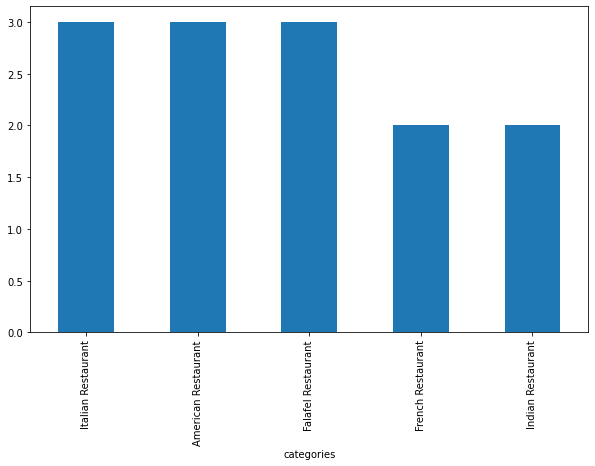

In [67]:
#plotting the top five restaurant categories
trending_restaurants.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in London') # add title to the plot

plt.show()

In [68]:
#counting hotels in each area to evaluate potential
hotels_count = clustered_hotels['cluster_label'].value_counts().rename_axis('cluster').reset_index(name='counts')
hotels_count

,cluster,counts
0,2,5
1,1,5
2,0,4
